In [1]:
import numpy as np
import pandas as pd
import itertools
import re
import os
import difflib
import random
import requests
import ipywidgets as widgets
import matplotlib.pyplot as plt
import seaborn as sns

import Pre_process.pre_process as pre_process 
import M_Arc_Dict.model_dict as model_dict
import M_Create.rl_model_search as rl_model_search

from keras.callbacks import ModelCheckpoint
from keras.models import load_model

Using TensorFlow backend.


In [2]:
def multi_checkbox_widget(descriptions):
    """ Widget with a search field and lots of checkboxes """
#     search_widget = widgets.Text()
    options_dict = {description: widgets.Checkbox(description=description, value=False) for description in descriptions}
    options = [options_dict[description] for description in descriptions]
    options_widget = widgets.VBox(options, layout={'overflow': 'scroll'})
    multi_select = widgets.VBox([options_widget])
    
    return multi_select

def get_features_list(features_tmp):
    arr = []
    for i in range(len(features_tmp.children[0].children)):
        if features_tmp.children[0].children[i].value == True:
            description = features_tmp.children[0].children[i].description
            arr.append(description)
    return arr

In [3]:
#load Data sample data
df_data = pd.read_csv('Data_Store/sample_data.csv').head()

In [33]:
from ipywidgets import Layout, Button, Box, FloatText, Textarea, Dropdown, Label, IntSlider
features = multi_checkbox_widget(df_data.columns)
target = multi_checkbox_widget(df_data.columns)
model_l = multi_checkbox_widget(['LSTM','CNN','CLSTM'])

form_item_layout = Layout(
    display='flex',
    flex_flow='flex-wrap',
)

form_items = [
    Box([Label(value='Choose multiple input features'), features], layout=form_item_layout),
    Box([Label(value='Choose one target'), target], layout=form_item_layout),
    Box([Label(value='Choose Model'), model_l], layout=form_item_layout),
    
]

form = Box(form_items, layout=Layout(
    display='flex',
    flex_flow='flex-wrap',
    border='solid 2px',

))

form

Box(children=(Box(children=(Label(value='Choose multiple input features'), VBox(children=(VBox(children=(Check…

### Please choose 'group', 'dayofyear', '20' in this current version

In [5]:
from ipywidgets import Layout, Button, Box, FloatText, Textarea, Dropdown, Label, IntSlider
features = multi_checkbox_widget(df_data.columns)
target = multi_checkbox_widget(df_data.columns)
model_l = multi_checkbox_widget(['LSTM','CNN','CLSTM'])

form_item_layout = Layout(
    display='flex',
    flex_flow='flex-wrap',
)

form_items = [
    Box([Label(value='Choose Deep Learning Models'), model_l], layout=form_item_layout),
    
]

form = Box(form_items, layout=Layout(
    display='flex',
    flex_flow='flex-wrap',
    border='solid 3px',
    width = '50%'

))

form

Box(children=(Box(children=(Label(value='Choose Deep Learning Models'), VBox(children=(VBox(children=(Checkbox…

In [6]:
from ipywidgets import Layout, Button, Box, FloatText, Textarea, Dropdown, Label, IntSlider
loss_l = multi_checkbox_widget(['mean_squared_error','mean_absolute_error','mean_absolute_percentage_error','mean_squared_logarithmic_error'
,'squared_hinge','hinge','logcosh'])

form_item_layout = Layout(
    display='flex',
    flex_flow='flex-wrap',
)

form_items = [
    Box([Label(value='Choose Loss Function'), loss_l], layout=form_item_layout),
    
]

form = Box(form_items, layout=Layout(
    display='flex',
    flex_flow='flex-wrap',
    border='solid 2px',

))

form

Box(children=(Box(children=(Label(value='Choose Loss Function'), VBox(children=(VBox(children=(Checkbox(value=…

# Example of model searching and selection

In [42]:
#Deep Learning models related parameters
features_cols = get_features_list(features)
target_label = get_features_list(target)
model_list = get_features_list(model_l)
#defining activation function and loss function
output_act ='relu'
loss_fun = get_features_list(loss_l)[0]
metrics = ['loss']

#defining input and output shape
window_size = 2
num_neighbors = 1
output_shape = 1

#dataset related parameters
find_mem_from = 'group'
find_mem_basedon = '20'
sequence_by  = 'dayofyear'

#search space prameters
max_layers = 20
min_layers = 1
max_cells = 200
min_cells = 10
layer_step_size = 1
cell_step_size = 1

#q_learning prameters
alpha = 1.0
gamma = 1.0

#simulation parameters
N_MODELS = 1 # number of models to search
MIN_ALPHA = 0.01
threshold = np.linspace(1.0, MIN_ALPHA, N_MODELS) #threshold for explore and exploite
callbacks = []

#training related parameters
verbose, nr_epochs, batch_size = 0, 200, 500

window_list = [1,2,3,4,5,6,7,8,9,10,11,12,13,14]
sort_value_by = '20'
problem = 'access_window_mse'
explore = 0

In [43]:
model_config = pd.DataFrame({0:[],1:[],2:[],'model_type':[],'layer_type':[],'config_type':[]})

In [44]:
model_config[0]= ['[100 , 100, 100]']
model_config[1]=['[300]']
model_config['model_type']=['LSTM']
model_config['config_type']=['(3,1)']
model_config['layer_type']=['4']

In [45]:
model_config

,0,1,2,model_type,layer_type,config_type
0,"[100 , 100, 100]",[300],NaN,LSTM,4,"(3,1)"


In [69]:
for window_size in window_list:
    input_shape = [window_size,len(features_cols)*num_neighbors]
    
    #creating training dataset
    x_train = []
    y_train = []
    data_set = ['sample_data']    
    num_xsamples = 0
    num_ysamples = 0
    for data in data_set:
        df_data = pd.read_csv('Data_Store/'+data+'.csv')
        x_train_tmp, y_train_tmp = pre_process.get_train_data(df_data,find_mem_from,find_mem_basedon,sequence_by,window_size,num_neighbors,features_cols,target_label)
    
        x_train.append(x_train_tmp)
        y_train.append(y_train_tmp)
    
    for i in range(len(x_train)):
        num_xsamples += len(x_train[i])
        num_ysamples += len(y_train[i])

    x_train = np.reshape(x_train,(num_xsamples,window_size,len(features_cols)*num_neighbors))
    y_train = np.reshape(y_train,(num_ysamples,1))

    #spliting validating and training dataset
    train_range = int(np.ceil(len(x_train)*0.8))
    x_val = x_train[train_range:]
    y_val = y_train[train_range:]
    
    x_train = x_train[0:train_range]
    y_train = y_train[0:train_range]
#     df_data = pd.read_csv('dataset/2016.csv')
    # df_data = df_data[df_data[sequence_by].isin(np.arange(2,100))]
#     x_val, y_val = pre_process.get_train_data(df_data,find_mem_from,find_mem_basedon,sequence_by,window_size,num_neighbors,features_cols,target_label)
    
    #create q_table
    model_tab = pd.DataFrame({'model_type':[],'q':[]})
    layer_tab = pd.DataFrame({'model_type':[],'layer_type':[],'q':[]})
    config_tab = pd.DataFrame({'model_type':[],'layer_type':[],'config_type':[],'q':[]})

    model_tab_log = pd.DataFrame({'model_type':[],'q':[]})
    layer_tab_log = pd.DataFrame({'model_type':[],'layer_type':[],'q':[]})
    config_tab_log = pd.DataFrame({'model_type':[],'layer_type':[],'config_type':[],'q':[]})
    
    his = pd.DataFrame()
    #generate model_info to create search space
    model_info = rl_model_search.gen_com_model(model_list,max_layers,layer_step_size)

    #stat collector
    his_log_save = 'his/'+problem+'/'
    emdf_save = his_log_save+'em_log'+str(window_size)+str(num_neighbors)+'.csv'
    
    

    for i in range(N_MODELS):            
        #Get configuration
        print(model_config)
        model_type = model_config['model_type'].values[0]
        layer_type = model_config['layer_type'].values[0]
        config_type = model_config['config_type'].values[0]

        if not os.path.exists(his_log_save):
            os.makedirs(his_log_save)
        
        

        #Training and validation process
        model = model_dict.get_explored_prediction_model(input_shape, output_shape, model_config, output_act, loss_fun, metrics=['loss'])

    
        time_callback = model_dict.TimeHistory()
        history = model.fit(x_train, y_train,
                        epochs=nr_epochs, batch_size=batch_size,
                        validation_data=(x_val, y_val),
                        verbose=verbose,
                        callbacks=[time_callback])
        
        each_mdf = pd.DataFrame(history.history)  
        each_mdf[0]=str(model_config[0].values[0])
        each_mdf[1] = str(model_config[1].values[0])
        if model_type == 'CLSTM':
            each_mdf[2] = str(model_config[2])
        else:
            each_mdf[2] = 'nan'
            model_config[2] = 0
        each_mdf['model_type']= model_type
        each_mdf['layer_type']= layer_type
        each_mdf['config_type'] = str(config_type)
        each_mdf['tslot'] = window_size
        each_mdf['dimen'] = num_neighbors
        each_mdf['time'] = time_callback.times
        each_mdf['exp'] = explore


        cols = [0,1,2,'acc','loss','val_acc','val_loss','model_type','layer_type','config_type','tslot','dimen','time','exp']
        each_mdf = each_mdf.reindex(cols,axis=1)
        if not os.path.isfile(emdf_save):
                each_mdf.to_csv(emdf_save,header='colum_names',index=None)
        else:
            each_mdf.to_csv(emdf_save,mode = 'a',header=False,index=None)   
        
        reward = each_mdf['val_loss'].mean()
        model_config['reward']= reward
        model_config['time']= each_mdf['time'].mean()
        model_config['exp']=explore
        
        cols = [0,1,2,'model_type','config_type','layer_type','reward','time','exp']
        model_config = model_config.reindex(cols,axis=1)
        if not os.path.isfile(his_log_save+'his'+str(window_size)+str(num_neighbors)+'.csv'):
            model_config.to_csv(his_log_save+'his'+str(window_size)+str(num_neighbors)+'.csv',index=None,header='colum_names')
        else:
            model_config.to_csv(his_log_save+'his'+str(window_size)+str(num_neighbors)+'.csv',index=None,mode = 'a',header=False)   
        
        #update q tables 
        model_tab, model_tab_log = rl_model_search.up_model_q(reward,model_tab,model_tab_log,model_type,layer_tab,layer_type,alpha,gamma)
        layer_tab, layer_tab_log = rl_model_search.up_layer_q(reward,layer_tab,layer_tab_log,model_type,layer_type,config_tab,config_type,alpha,gamma)
        config_tab, config_tab_log = rl_model_search.up_config_q(reward,config_tab,config_tab_log,model_type,layer_type,config_type,alpha,gamma)
    
        model_tab_log.to_csv(his_log_save+'model_tab'+str(window_size)+str(num_neighbors)+'.csv',index=None)
        layer_tab_log.to_csv(his_log_save+'layer_tab'+str(window_size)+str(num_neighbors)+'.csv',index=None)
        config_tab_log.to_csv(his_log_save+'config_tab'+str(window_size)+str(num_neighbors)+'.csv',index=None)

                  0      1  2 model_type config_type layer_type    reward  \
0  [100 , 100, 100]  [300]  0       LSTM       (3,1)          4  0.000129   

       time  exp  
0  0.629212    0  
                  0      1  2 model_type config_type layer_type   reward  \
0  [100 , 100, 100]  [300]  0       LSTM       (3,1)          4  0.00013   

       time  exp  
0  0.053906    0  
                  0      1  2 model_type config_type layer_type    reward  \
0  [100 , 100, 100]  [300]  0       LSTM       (3,1)          4  0.000129   

      time  exp  
0  0.08537    0  
                  0      1  2 model_type config_type layer_type    reward  \
0  [100 , 100, 100]  [300]  0       LSTM       (3,1)          4  0.000128   

       time  exp  
0  0.113936    0  
                  0      1  2 model_type config_type layer_type    reward  \
0  [100 , 100, 100]  [300]  0       LSTM       (3,1)          4  0.000127   

      time  exp  
0  0.14572    0  
                  0      1  2 model_type 

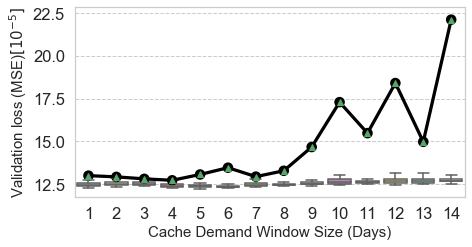

In [80]:
####Cache demand
x_data = "tslot"
y_data =  "val_loss"

df_tmp = pd.DataFrame() 
for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14]:
    df_tmp=df_tmp.append(pd.read_csv('his/access_window_mse/em_log'+str(i)+'1.csv')).fillna(0)

sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
ax = plt.figure(figsize=(7,3.5))
ax = sns.boxplot(x=x_data, y=y_data,data=df_tmp, palette="Set3",showmeans=True,showfliers=False)
df_mean=df_tmp.groupby([x_data])[y_data].mean().reset_index()
ax=sns.pointplot(x=x_data, y=y_data, data=df_mean,color='black',scale=1.2,markers='o')

ylabels = ['{:,.1f}'.format(x) for x in ax.get_yticks()*100000]
ax.set_yticklabels(ylabels)

plt.xlabel('Groups')
plt.ylabel('20% Movie Counts')
# ax.legend_.remove()
_=plt.xlabel('Cache Demand Window Size (Days)',fontsize=15)
_=plt.ylabel('Validation loss (MSE)$[10^{-5}]$',fontsize=15)
plt.savefig('Plots/cache_window.png',dpi=300, bbox_inches = 'tight')

In [107]:
# ####Cache demand
# x_data = "tslot"
# y_data =  "val_loss"

# df_tmp = pd.DataFrame() 
# for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14]:
# # for i in [1,2,3,4,5,6,7]:
#     df_tmp=df_tmp.append(pd.read_csv('his/demo_window_2f/em_log'+str(i)+'1.csv')).fillna(0)

# sns.set(font_scale=1.5)
# sns.set_style("whitegrid", {'grid.linestyle': '--'})
# ax = plt.figure(figsize=(7,3.5))
# ax = sns.boxplot(x=x_data, y=y_data,data=df_tmp, palette="Set3",showmeans=False,showfliers=False)
# df_mean=df_tmp.groupby([x_data])[y_data].mean().reset_index()
# ax=sns.pointplot(x=x_data, y=y_data, data=df_mean,color='black',scale=1.2,markers='o')

# ylabels = ['{:,.1f}'.format(x) for x in ax.get_yticks()*100000]
# ax.set_yticklabels(ylabels)

# plt.xlabel('Groups')
# plt.ylabel('20% Movie Counts')
# # ax.legend_.remove()
# _=plt.xlabel('Cache Demand Window Size (Days)',fontsize=15)
# _=plt.ylabel('Validation loss (MSE)$[10^{-5}]$',fontsize=15)
# plt.savefig('Plots/cache_window.png',dpi=300, bbox_inches = 'tight')

In [ ]:
neighbor_list = [1,2,3]
sort_value_by = '20'
problem = 'access_neighbor_mse'
explore = 0
window_size = 4

for num_neighbors in neighbor_list:
    input_shape = [window_size,len(features_cols)*num_neighbors]
    
    #creating training dataset
    x_train = []
    y_train = []
    data_set = ['sample_data']    
    num_xsamples = 0
    num_ysamples = 0
    for data in data_set:
        df_data = pd.read_csv('Data_Store/'+data+'.csv')
#     df_data = df_data[df_data[sequence_by].isin(np.arange(2,100))]
        x_train_tmp, y_train_tmp = pre_process.get_train_data(df_data,find_mem_from,find_mem_basedon,sequence_by,window_size,num_neighbors,features_cols,target_label)
    
        x_train.append(x_train_tmp)
        y_train.append(y_train_tmp)
    
    for i in range(len(x_train)):
        num_xsamples += len(x_train[i])
        num_ysamples += len(y_train[i])

    x_train = np.reshape(x_train,(num_xsamples,window_size,len(features_cols)*num_neighbors))
    y_train = np.reshape(y_train,(num_ysamples,1))

    #spliting validating and training dataset
    train_range = int(np.ceil(len(x_train)*0.8))
    x_val = x_train[train_range:]
    y_val = y_train[train_range:]
    
    x_train = x_train[0:train_range]
    y_train = y_train[0:train_range]
    #creating validating dataset
#     df_data = pd.read_csv('dataset/2016.csv')
    # df_data = df_data[df_data[sequence_by].isin(np.arange(2,100))]
#     x_val, y_val = pre_process.get_train_data(df_data,find_mem_from,find_mem_basedon,sequence_by,window_size,num_neighbors,features_cols,target_label)


    
    #create q_table
    model_tab = pd.DataFrame({'model_type':[],'q':[]})
    layer_tab = pd.DataFrame({'model_type':[],'layer_type':[],'q':[]})
    config_tab = pd.DataFrame({'model_type':[],'layer_type':[],'config_type':[],'q':[]})

    model_tab_log = pd.DataFrame({'model_type':[],'q':[]})
    layer_tab_log = pd.DataFrame({'model_type':[],'layer_type':[],'q':[]})
    config_tab_log = pd.DataFrame({'model_type':[],'layer_type':[],'config_type':[],'q':[]})
    
    his = pd.DataFrame()
    #generate model_info to create search space
    model_info = rl_model_search.gen_com_model(model_list,max_layers,layer_step_size)

    #stat collector
    his_log_save = 'his/'+problem+'/'
    emdf_save = his_log_save+'em_log'+str(window_size)+str(num_neighbors)+'.csv'
    
    

    for i in range(N_MODELS):

        ##### RL based model search    
        if np.random.uniform(0,1)< threshold[i]:
            print('explore',i)
            #Explore model configuration
            model_config, model_info, model_tab,layer_tab,config_tab = rl_model_search.exploration(model_info,model_tab,layer_tab,config_tab,min_cells,max_cells,cell_step_size)  
            explore = 0
        else:
            #exploitation
            print('exploite',i)
            model_config, model_tab,layer_tab,config_tab = rl_model_search.exploitation(model_tab,layer_tab,config_tab,min_cells,max_cells,cell_step_size)
            explore = 1
            
        #Get configuration
        model_type = model_config['model_type'].values[0]
        layer_type = model_config['layer_type'].values[0]
        config_type = model_config['config_type'].values[0]

        if not os.path.exists(his_log_save):
            os.makedirs(his_log_save)
        
        

        #Training and validation process
        model = model_dict.get_explored_prediction_model(input_shape, output_shape, model_config, output_act, loss_fun, metrics=['loss'])

    
        time_callback = model_dict.TimeHistory()
        history = model.fit(x_train, y_train,
                        epochs=nr_epochs, batch_size=batch_size,
                        validation_data=(x_val, y_val),
                        verbose=verbose,
                        callbacks=[time_callback])
        
        each_mdf = pd.DataFrame(history.history)  
        each_mdf[0]=str(model_config[0].values[0])
        each_mdf[1] = str(model_config[1].values[0])
        if model_type == 'CLSTM':
            each_mdf[2] = str(model_config[2])
        else:
            each_mdf[2] = 'nan'
            model_config[2] = 0
        each_mdf['model_type']= model_type
        each_mdf['layer_type']= layer_type
        each_mdf['config_type'] = str(config_type)
        each_mdf['tslot'] = window_size
        each_mdf['dimen'] = num_neighbors
        each_mdf['time'] = time_callback.times
        each_mdf['exp'] = explore


        cols = [0,1,2,'acc','loss','val_acc','val_loss','model_type','layer_type','config_type','tslot','dimen','time','exp']
        each_mdf = each_mdf.reindex(cols,axis=1)
        if not os.path.isfile(emdf_save):
                each_mdf.to_csv(emdf_save,header='colum_names',index=None)
        else:
            each_mdf.to_csv(emdf_save,mode = 'a',header=False,index=None)   
        
        reward = each_mdf['val_loss'].mean()
        model_config['reward']= reward
        model_config['time']= each_mdf['time'].mean()
        model_config['exp']=explore
        
        cols = [0,1,2,'model_type','config_type','layer_type','reward','time','exp']
        model_config = model_config.reindex(cols,axis=1)
        if not os.path.isfile(his_log_save+'his'+str(window_size)+str(num_neighbors)+'.csv'):
            model_config.to_csv(his_log_save+'his'+str(window_size)+str(num_neighbors)+'.csv',index=None,header='colum_names')
        else:
            model_config.to_csv(his_log_save+'his'+str(window_size)+str(num_neighbors)+'.csv',index=None,mode = 'a',header=False)   
        
        #update q tables 
        model_tab, model_tab_log = rl_model_search.up_model_q(reward,model_tab,model_tab_log,model_type,layer_tab,layer_type,alpha,gamma)
        layer_tab, layer_tab_log = rl_model_search.up_layer_q(reward,layer_tab,layer_tab_log,model_type,layer_type,config_tab,config_type,alpha,gamma)
        config_tab, config_tab_log = rl_model_search.up_config_q(reward,config_tab,config_tab_log,model_type,layer_type,config_type,alpha,gamma)
    
        model_tab_log.to_csv(his_log_save+'model_tab'+str(window_size)+str(num_neighbors)+'.csv',index=None)
        layer_tab_log.to_csv(his_log_save+'layer_tab'+str(window_size)+str(num_neighbors)+'.csv',index=None)
        config_tab_log.to_csv(his_log_save+'config_tab'+str(window_size)+str(num_neighbors)+'.csv',index=None)

In [108]:
def find_nearest_neighbor(df_data,find_mem_from,find_mem_basedon,num_neighbors,day,window_size,sequence_by,data_range):
    day_range=day-np.flip(np.arange(window_size), 0)
    df_data_tmp = df_data[df_data[sequence_by]==day].sort_values(by='req',ascending=False)[0:data_range ]
    #To find the similar neigbor for training
    potential_member = df_data_tmp[find_mem_from].unique()
    print(potential_member)
    dict_tmp = {k: v for v, k in enumerate(potential_member)}
    dict_tmp = {y:x for x,y in dict_tmp.items()}
#     print(dict_tmp)
    X = df_data[df_data[sequence_by].isin(day_range) & (df_data[find_mem_from].isin(potential_member))].reset_index().pivot(index=find_mem_from,columns=sequence_by,values=find_mem_basedon)
#     print(X)
    X_index = X.index
    X = X.values

    nbrs = NearestNeighbors(n_neighbors=num_neighbors, algorithm='ball_tree').fit(X)
    distances, indices = nbrs.kneighbors(X)
    tmp_df = pd.DataFrame(indices)
    tmp_df = tmp_df.replace(dict_tmp)
    X = tmp_df.values 
    
    return X


def get_train_data(df_data, find_mem_from, find_mem_basedon, sequence_by, window_size, num_neighbors, features_cols,
                   target_label,data_range ):
    x_train = []
    y_train = pd.DataFrame()
    
#     mem_counter = 0
    for day in df_data.dayofyear.unique()[window_size - 1:-1]:
        print(day)
        n_neighbor = find_nearest_neighbor(df_data, find_mem_from, find_mem_basedon, num_neighbors, day, window_size,
                                           sequence_by,data_range )
#         print(n_neighbor)
        day_range = day - np.flip(np.arange(window_size), 0)
        print(day_range)
        df_pop = df_data[df_data[sequence_by]==day].sort_values(by='req',ascending=False)[0:data_range][find_mem_from].unique()
        df_tmp = df_data[df_data[sequence_by].isin(day_range) & df_data[find_mem_from].isin(df_pop)]
#         print(df_tmp)
#         mem_counter += len(df_pop)
        for i in range(len(n_neighbor)):
            x_tmp = df_tmp[df_tmp[find_mem_from].isin(n_neighbor[i])][features_cols]
#             print(x_tmp)
            for r in range(int(len(x_tmp) / num_neighbors)):
                for k in range(num_neighbors):
                    if k == 0:
                        row_num = r
#                         print(x_tmp.iloc[row_num].values)
                        x_train.append(x_tmp.iloc[row_num].values)
                    else:
                        row_num += window_size
#                         print(x_tmp.iloc[row_num].values)
                        x_train.append(x_tmp.iloc[row_num].values)
        
        y_tmp = df_tmp[df_tmp[sequence_by].isin([day])][target_label]
        y_train = y_train.append(y_tmp, ignore_index=True)

    x_train = np.reshape(x_train, (
    len(df_data.dayofyear.unique()[window_size - 1:-1]) * data_range, window_size,
    num_neighbors * len(features_cols)))
    y_train = y_train.values

    return x_train, y_train   

In [83]:
#Deep Learning models related parameters
features_cols = get_features_list(features)
target_label = get_features_list(target)
model_list = get_features_list(model_l)
#defining activation function and loss function
output_act ='relu'
loss_fun = 'mse'
metrics = ['loss']

#defining input and output shape
window_size = 9
num_neighbors = 3
input_shape = [window_size,len(features_cols)*num_neighbors]
output_shape = 1

#dataset related parameters
find_mem_from = 'group'
find_mem_basedon = '20'
sequence_by  = 'dayofyear'

#search space prameters
max_layers = 20
min_layers = 1
max_cells = 300
min_cells = 10
layer_step_size = 1
cell_step_size = 1

#q_learning prameters
alpha = 1.0
gamma = 1.0

#simulation parameters
N_MODELS = 100 # number of models to search
MIN_ALPHA = 0.01
threshold = np.linspace(1.0, MIN_ALPHA, N_MODELS) #threshold for explore and exploite
callbacks = []

#training related parameters
verbose, nr_epochs, batch_size = 0, 500, 500

# data_range = 3
#creating training dataset
x_train = []
y_train = []
data_set = ['sample_data']    
num_xsamples = 0
num_ysamples = 0
for data in data_set:
    df_data = pd.read_csv('dataset/'+data+'.csv')
#     df_data = df_data[df_data[sequence_by].isin(np.arange(2,100))]
    x_train_tmp, y_train_tmp = pre_process.get_train_data(df_data,find_mem_from,find_mem_basedon,sequence_by,window_size,num_neighbors,features_cols,target_label)
    
    x_train.append(x_train_tmp)
    y_train.append(y_train_tmp)
    
for i in range(len(x_train)):
    num_xsamples += len(x_train[i])
    num_ysamples += len(y_train[i])

x_train = np.reshape(x_train,(num_xsamples,window_size,len(features_cols)*num_neighbors))
y_train = np.reshape(y_train,(num_ysamples,1))

#creating validating dataset
df_data = pd.read_csv('dataset/2016.csv')
# df_data = df_data[df_data[sequence_by].isin(np.arange(2,100))]
x_val, y_val =pre_process.get_train_data(df_data,find_mem_from,find_mem_basedon,sequence_by,window_size,num_neighbors,features_cols,target_label)



FileNotFoundError: [Errno 2] File b'dataset/sample_data.csv' does not exist: b'dataset/sample_data.csv'

In [8]:
window_list = [9]
sort_value_by = '20'
problem = 'access_model_find_mse_10002'
explore = 0

for window_size in window_list:
    input_shape = [window_size,len(features_cols)*num_neighbors]
    
    #creating training dataset
    x_train = []
    y_train = []
    data_set = ['2015']    
    num_xsamples = 0
    num_ysamples = 0
    for data in data_set:
        df_data = pd.read_csv('dataset/'+data+'.csv')
#     df_data = df_data[df_data[sequence_by].isin(np.arange(2,100))]
        x_train_tmp, y_train_tmp = pre_process.get_train_data(df_data,find_mem_from,find_mem_basedon,sequence_by,window_size,num_neighbors,features_cols,target_label)
    
        x_train.append(x_train_tmp)
        y_train.append(y_train_tmp)
    
    for i in range(len(x_train)):
        num_xsamples += len(x_train[i])
        num_ysamples += len(y_train[i])

    x_train = np.reshape(x_train,(num_xsamples,window_size,len(features_cols)*num_neighbors))
    y_train = np.reshape(y_train,(num_ysamples,1))

    #creating validating dataset
    df_data = pd.read_csv('dataset/2016.csv')
    # df_data = df_data[df_data[sequence_by].isin(np.arange(2,100))]
    x_val, y_val = pre_process.get_train_data(df_data,find_mem_from,find_mem_basedon,sequence_by,window_size,num_neighbors,features_cols,target_label)


    
    #create q_table
    model_tab = pd.DataFrame({'model_type':[],'q':[]})
    layer_tab = pd.DataFrame({'model_type':[],'layer_type':[],'q':[]})
    config_tab = pd.DataFrame({'model_type':[],'layer_type':[],'config_type':[],'q':[]})

    model_tab_log = pd.DataFrame({'model_type':[],'q':[]})
    layer_tab_log = pd.DataFrame({'model_type':[],'layer_type':[],'q':[]})
    config_tab_log = pd.DataFrame({'model_type':[],'layer_type':[],'config_type':[],'q':[]})
    
    his = pd.DataFrame()
    #generate model_info to create search space
    model_info = rl_model_search.gen_com_model(model_list,max_layers,layer_step_size)

    #stat collector
    his_log_save = 'his/'+problem+'/'
    emdf_save = his_log_save+'em_log'+str(window_size)+str(num_neighbors)+'.csv'
    
    

    for i in range(N_MODELS):

        ##### RL based model search    
        if np.random.uniform(0,1)< threshold[i]:
            print('explore',i)
            #Explore model configuration
            model_config, model_info, model_tab,layer_tab,config_tab = rl_model_search.exploration(model_info,model_tab,layer_tab,config_tab,min_cells,max_cells,cell_step_size)  
            explore = 0
        else:
            #exploitation
            print('exploite',i)
            model_config, model_tab,layer_tab,config_tab = rl_model_search.exploitation(model_tab,layer_tab,config_tab,min_cells,max_cells,cell_step_size)
            explore = 1
            
        #Get configuration
        model_type = model_config['model_type'].values[0]
        layer_type = model_config['layer_type'].values[0]
        config_type = model_config['config_type'].values[0]

        if not os.path.exists(his_log_save):
            os.makedirs(his_log_save)
        
        

        #Training and validation process
        model = model_dict.get_explored_prediction_model(input_shape, output_shape, model_config, output_act, loss_fun, metrics=['loss'])

    
        time_callback = model_dict.TimeHistory()
        history = model.fit(x_train, y_train,
                        epochs=nr_epochs, batch_size=batch_size,
                        validation_data=(x_val, y_val),
                        verbose=verbose,
                        callbacks=[time_callback])
        
        each_mdf = pd.DataFrame(history.history)  
        each_mdf[0]=str(model_config[0].values[0])
        each_mdf[1] = str(model_config[1].values[0])
        if model_type == 'CLSTM':
            each_mdf[2] = str(model_config[2])
        else:
            each_mdf[2] = 'nan'
            model_config[2] = 0
        each_mdf['model_type']= model_type
        each_mdf['layer_type']= layer_type
        each_mdf['config_type'] = str(config_type)
        each_mdf['tslot'] = window_size
        each_mdf['dimen'] = num_neighbors
        each_mdf['time'] = time_callback.times
        each_mdf['exp'] = explore


        cols = [0,1,2,'acc','loss','val_acc','val_loss','model_type','layer_type','config_type','tslot','dimen','time','exp']
        each_mdf = each_mdf.reindex(cols,axis=1)
        if not os.path.isfile(emdf_save):
                each_mdf.to_csv(emdf_save,header='colum_names',index=None)
        else:
            each_mdf.to_csv(emdf_save,mode = 'a',header=False,index=None)   
        
        reward = each_mdf['val_loss'].mean()
        model_config['reward']= reward
        model_config['time']= each_mdf['time'].mean()
        model_config['exp']=explore
        
        cols = [0,1,2,'model_type','config_type','layer_type','reward','time','exp']
        model_config = model_config.reindex(cols,axis=1)
        if not os.path.isfile(his_log_save+'his'+str(window_size)+str(num_neighbors)+'.csv'):
            model_config.to_csv(his_log_save+'his'+str(window_size)+str(num_neighbors)+'.csv',index=None,header='colum_names')
        else:
            model_config.to_csv(his_log_save+'his'+str(window_size)+str(num_neighbors)+'.csv',index=None,mode = 'a',header=False)   
        
        #update q tables 
        model_tab, model_tab_log = rl_model_search.up_model_q(reward,model_tab,model_tab_log,model_type,layer_tab,layer_type,alpha,gamma)
        layer_tab, layer_tab_log = rl_model_search.up_layer_q(reward,layer_tab,layer_tab_log,model_type,layer_type,config_tab,config_type,alpha,gamma)
        config_tab, config_tab_log = rl_model_search.up_config_q(reward,config_tab,config_tab_log,model_type,layer_type,config_type,alpha,gamma)
    
        model_tab_log.to_csv(his_log_save+'model_tab'+str(window_size)+str(num_neighbors)+'.csv',index=None)
        layer_tab_log.to_csv(his_log_save+'layer_tab'+str(window_size)+str(num_neighbors)+'.csv',index=None)
        config_tab_log.to_csv(his_log_save+'config_tab'+str(window_size)+str(num_neighbors)+'.csv',index=None)

explore 0
Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
explore 1
explore 2
explore 3
explore 4
explore 5
explore 6
explore 7
explore 8
exploite 9


/home/kt/PycharmProjects/rlml_imp_proto/rl_model_search.py:111: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  config_type = config_type[config_tab['q'] == config_type['q'].min()]


explore 10
explore 11
explore 12
explore 13
explore 14
explore 15
explore 16
explore 17
explore 18
exploite 19
explore 20
explore 21
explore 22
explore 23
explore 24
explore 25
explore 26
exploite 27
exploite 28
exploite 29
explore 30
explore 31
explore 32
exploite 33
explore 34
explore 35
explore 36
exploite 37
explore 38
exploite 39
explore 40
explore 41
exploite 42
explore 43
explore 44
explore 45
explore 46
exploite 47
exploite 48
explore 49
exploite 50
explore 51
explore 52
explore 53
exploite 54
explore 55
exploite 56
exploite 57
explore 58
exploite 59
exploite 60
explore 61
explore 62
exploite 63
exploite 64
exploite 65
explore 66
explore 67
explore 68
exploite 69
exploite 70
explore 71
exploite 72
exploite 73
explore 74
exploite 75
exploite 76
explore 77
exploite 78
explore 79
explore 80
exploite 81
exploite 82
exploite 83
exploite 84
exploite 85
exploite 86
exploite 87
exploite 88
explore 89
exploite 90
exploite 91
exploite 92
explore 93
exploite 94
exploite 95
exploite 96
exp